In [1]:
# needs data generated by created_dataset_2
# predicts genre by image (incl AR)

In [2]:
import re
import os
import keras
import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from itertools import combinations

%matplotlib inline

Using TensorFlow backend.


In [3]:
# np.random.seed(seed=100500)

In [4]:
TEST_SIZE = .25

In [16]:
X = np.load('out/X2.npy')
y = np.load('out/y2.npy')
labels = np.load('out/styles.npy')
X, y = shuffle(X, y)

In [6]:
# split data onto training/test sets
ntest = int(len(y) * TEST_SIZE)
y_train, y_test = (y[:-ntest], y[-ntest:])
X_train, X_test = (X[:-ntest], X[-ntest:])

In [7]:
X_train.shape[1]

2049

In [8]:
y_train.shape[1]

135

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D
from keras.regularizers import l2, activity_l2

model = Sequential([
    Dense(y_train.shape[1], input_dim=X_train.shape[1], activation='softmax',\
          W_regularizer=l2(0.001), b_regularizer=l2(0.001)),
#     Dropout(0.5),
#     Dense(64),
#     Dropout(0.5),
#     Dense(64),
#     Dropout(0.5),
#     Dense(y_train.shape[1]),
#     Activation('softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='SGD')

In [10]:
scores = []

# evaluate how many exact matches there are
def score_top1():
    s = 0
    n = X_test.shape[0]

    y_p = model.predict(X_test[s:s+n])
    yc = np.argmax(y_test[s:s+n], axis=1)
    ycp = np.argmax(y_p, axis=1)
    
    #     plt.figure(figsize=(20, 4))
    #     plt.plot(yc)
    #     plt.plot(ycp)

    m = 0.

    for i in range(len(yc)):
        if 0 == yc[i] - ycp[i]: m = m + 1.

    return m * 100. / len(yc) # % of top-1 hits

class MyCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        s = score_top1()
        scores.append(s)
        print "\n\n%3f %% top-1\n"%s
#     def on_epoch_end(self, epoch, logs={}):
#         s = score_top1()
#         scores.append(s)
#         print "\n\n%3f %% top-1\n"%s

In [11]:
# scores = []

hist = model.fit(
        X_train,
        y_train,
        batch_size=100,
        nb_epoch=10, 
        validation_data=(X_test, y_test),
        callbacks = [
            # keras.callbacks.TensorBoard(log_dir='/tmp/tb4', write_images=True),
            MyCallback()
        ]
     )

Train on 59001 samples, validate on 19667 samples


0.162709 % top-1

Epoch 1/10
59001/59001 [==============================] - 3s - loss: 3.5783 - val_loss: 3.2801


15.203132 % top-1

Epoch 2/10
59001/59001 [==============================] - 3s - loss: 3.1730 - val_loss: 3.1286


17.455636 % top-1

Epoch 3/10
59001/59001 [==============================] - 3s - loss: 3.0057 - val_loss: 3.0349


19.942035 % top-1

Epoch 4/10
59001/59001 [==============================] - 3s - loss: 2.8963 - val_loss: 2.7368


29.643565 % top-1

Epoch 5/10
59001/59001 [==============================] - 3s - loss: 2.8147 - val_loss: 2.6949


27.935120 % top-1

Epoch 6/10
59001/59001 [==============================] - 3s - loss: 2.7514 - val_loss: 2.8194


22.275894 % top-1

Epoch 7/10
59001/59001 [==============================] - 3s - loss: 2.6997 - val_loss: 2.5529


34.214674 % top-1

Epoch 8/10
59001/59001 [==============================] - 3s - loss: 2.6551 - val_loss: 2.5484


32.084202 % top-1

Ep

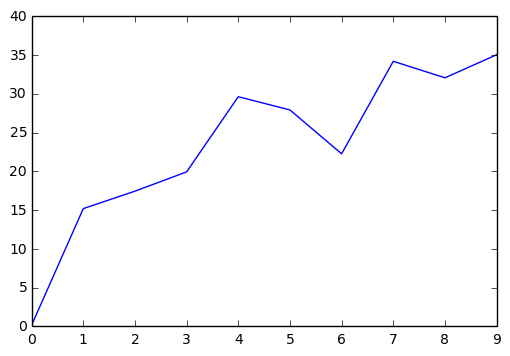

In [12]:
# plt.plot(hist.history['loss'])
plt.plot(np.array(scores)/1)

In [15]:
from keras.utils import visualize_util
visualize_util.plot(model, to_file='out/model.png', show_shapes=True)

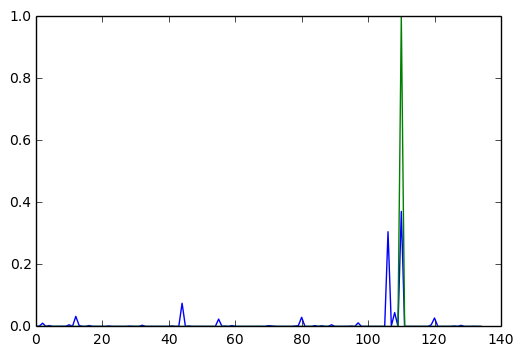

In [162]:
plt.plot(y_p[99])
plt.plot(y_test[99])

In [17]:
model.save('out/style-by-image.h5')